# HOT Comparison

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}

import xarray as xr
import numpy as np
import pandas as pd
#import modin.pandas as pdm
import os
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import skill_metrics as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
from plotting_tools.taylor_diagram import TaylorDiagram
from plotting_tools.target_diagram import TargetDiagram
from stats_tools.target_diagram import target_axes

In [3]:
import matplotlib.pyplot as PLT

# Load data

In [4]:
dir_tests = '/local/data/artemis/workspace/gloege/data/test_sets'
dir_prods = '/local/data/artemis/workspace/gloege/products/clean'

In [5]:
os.listdir(f'{dir_prods}')

['JMA-MLR_1x1_199001-201712.nc',
 'CSIR-ML6_1x1_198201-201612.nc',
 'FFNN-LSCE_1x1_200101-201711.nc',
 'SOM-FFN_1x1_198201-201512.nc',
 'NIES-NN_1x1_199001-201712.nc']

### test sets

In [6]:
BATS={'lat':31.83,
      'lon':360-(64.17)}

HOTS={'lat':22.75,
      'lon':360-158}

dir_data = '/local/data/artemis/workspace/gloege'
fl_hot = f'{dir_data}/data/HOT/HOT.nc'

ds_hot = xr.open_dataset(fl_hot)
ds_hot = ds_hot.where(ds_hot['spco2']>0)

In [7]:
ds_hot_mon = ds_hot.resample(time='1M').mean()


ds_hot_mon = ds_hot_mon.assign_coords(lon=(202.5),
                          lat=(22.5)).expand_dims(['lat','lon'])
ds_hot_mon = ds_hot_mon.transpose('time','lat','lon')

### ================================================
### force time vector to be proper format and range
### ================================================
dates = pd.date_range(start='1988-10-01T00:00:00.000000000', 
                  end='2017-12-01T00:00:00.000000000',
                      freq='MS')+ np.timedelta64(14, 'D')
da_dates = xr.DataArray(dates, dims='time')
ds_hot_mon['time'] = dates

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
ds_hot_mon = ds_hot_mon.squeeze()

### GCB model

In [9]:
dir_soc = '/local/data/artemis/workspace/gloege/LDEO-FFN/data/HPD_output/XGB'
#dir_soc='/local/data/artemis/workspace/myan/data/Apply_to_SOCAT'

# hybrid file dictionary
dict_spco2 = {'CCSM':  f'{dir_soc}/HPD-XGB_CCSM_spco2_1x1_mon_199801-201712.nc',
              'CNRM':  f'{dir_soc}/HPD-XGB_CNRM_spco2_1x1_mon_199801-201712.nc',
              'MPI':   f'{dir_soc}/HPD-XGB_MPI_spco2_1x1_mon_199801-201712.nc',
              'NEMO':  f'{dir_soc}/HPD-XGB_NEMO_spco2_1x1_mon_199801-201712.nc',
              'NORESM':f'{dir_soc}/HPD-XGB_NORESM_spco2_1x1_mon_199801-201712.nc',   
              'RECOM': f'{dir_soc}/HPD-XGB_RECOM_spco2_1x1_mon_199801-201712.nc',}

### Convert to model to dataframe
ds_mod = xr.open_mfdataset(dict_spco2.values(), concat_dim='models').mean('models')
ds_mod = ds_mod.transpose('time', 'lat', 'lon')

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  del sys.path[0]
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [10]:
### Defines directories
dir_soc='/local/data/artemis/workspace/myan/data/Apply_to_SOCAT'

### Load recitifed GCB models
dict_real = {
    'BEC':f'{dir_soc}/spco2_BEC_to_RealWorld_19980115-20171215.nc',
    'CNRM':f'{dir_soc}/spco2_CNRM-ESM2_to_RealWorld_19980115-20171215.nc',
#    'IPSL':f'{dir_soc}/spco2_IPSL-PISCES_to_RealWorld_19980115-20171215.nc',
    'MPI':f'{dir_soc}/spco2_MPI_to_RealWorld_19980115-20171215.nc',
    'NEMO':f'{dir_soc}/spco2_NEMO-planktom_to_RealWorld_19980115-20171215.nc',
    'NORESM':f'{dir_soc}/spco2_NorESM_to_RealWorld_19980115-20171215.nc',
    'RECOM':f'{dir_soc}/spco2_REcoM_jra_to_RealWorld_19980115-20171215.nc'}

### Convert to model to dataframe
ds_mod = xr.open_mfdataset(dict_real.values(), concat_dim='models').mean('models')
ds_mod = ds_mod.transpose('time', 'lat', 'lon')

### pCO2 products

In [10]:
ds_JMA_MLR = xr.open_dataset(f'{dir_prods}/JMA-MLR_1x1_199001-201712.nc')
ds_CSIR_ML6 = xr.open_dataset(f'{dir_prods}/CSIR-ML6_1x1_198201-201612.nc')
ds_NIES_NN = xr.open_dataset(f'{dir_prods}/NIES-NN_1x1_199001-201712.nc')
ds_SOM_FFN = xr.open_dataset(f'{dir_prods}/SOM-FFN_1x1_198201-201512.nc')
ds_FFNN_LSCE = xr.open_dataset(f'{dir_prods}/FFNN-LSCE_1x1_200101-201711.nc')

In [11]:
dir_data = '/local/data/artemis/workspace/gloege'

# BATS

In [12]:
(data_JMA_MLR, 
 data_CSIR_ML6, 
 data_NIES_NN, 
 data_SOM_FFN, 
 data_LDEO, 
 data_GCB, 
 data_HOT) = xr.align(ds_JMA_MLR['spco2'].load().sel(lat=HOTS['lat'], 
                         lon=HOTS['lon'], 
                         method='nearest'),
                    ds_CSIR_ML6['spco2'].load().sel(lat=HOTS['lat'], 
                         lon=HOTS['lon'], 
                         method='nearest'),
                    ds_NIES_NN['spco2'].load().sel(lat=HOTS['lat'], 
                         lon=HOTS['lon'], 
                         method='nearest'),
                    ds_SOM_FFN['spco2'].load().sel(lat=HOTS['lat'], 
                         lon=HOTS['lon'], 
                         method='nearest'), 
                    ds_mod['spco2_hpd'].load().sel(lat=HOTS['lat'], 
                         lon=HOTS['lon'], 
                         method='nearest'), 
                    ds_mod['spco2_model'].load().load().sel(lat=HOTS['lat'], 
                         lon=HOTS['lon'], 
                         method='nearest'),
                    ds_hot_mon['spco2'].load())

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [13]:
### Data Dictionary
data = {'JMA-MLR': data_JMA_MLR, 
        'CSIR-ML6': data_CSIR_ML6, 
        'NIES-NN': data_NIES_NN, 
        'SOM-FFN': data_SOM_FFN, 
        'LDEO-HMODEL': data_LDEO,
        'GCB': data_GCB,
        'HOT':data_HOT}

## Time series

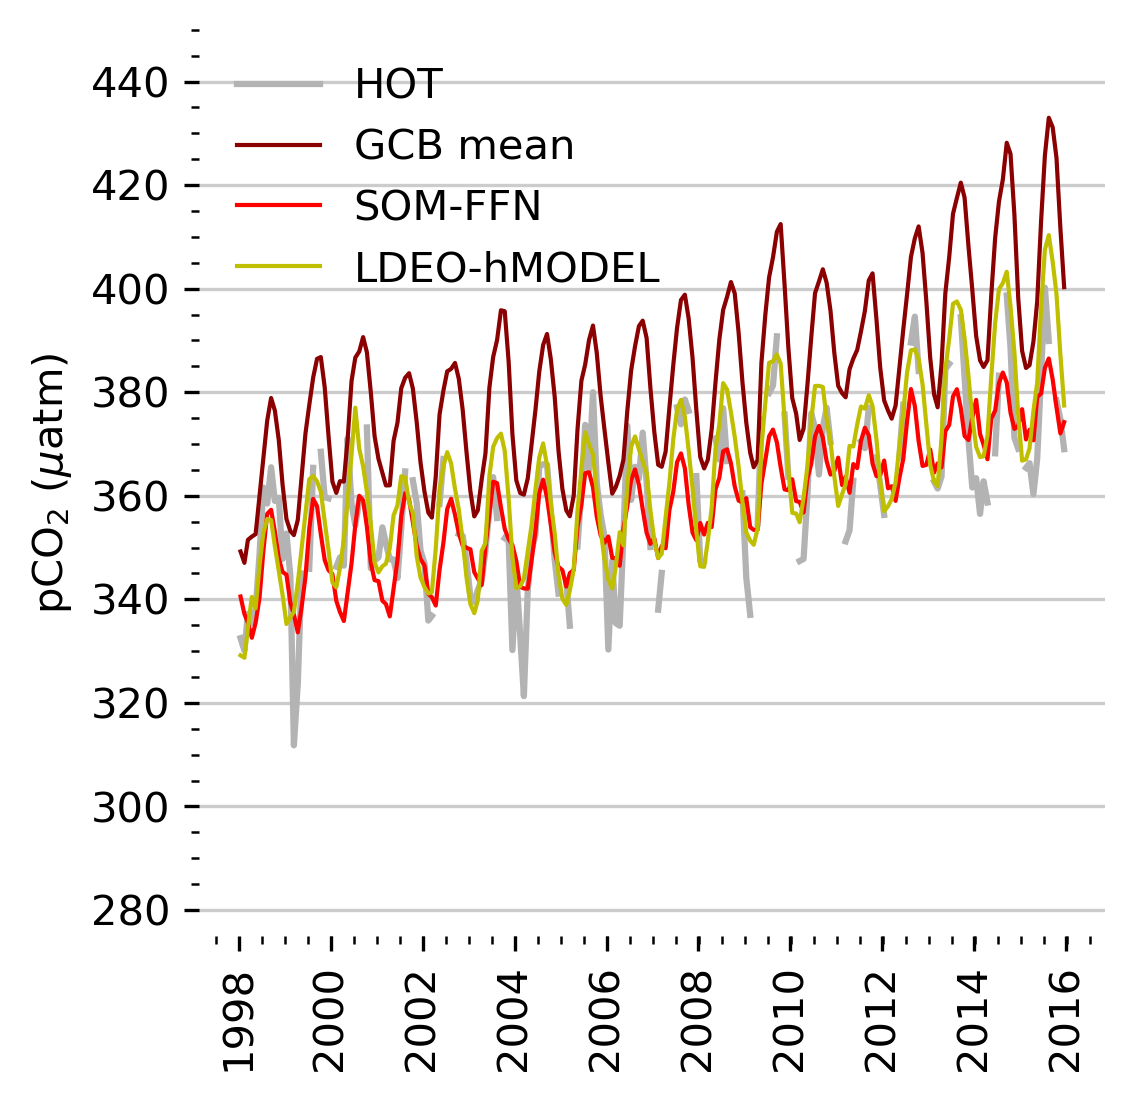

In [14]:
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot(111)

#plt.plot(data['NIES-NN']['time'], data['NIES-NN'])
ax.plot(data['HOT']['time'], data['HOT'], 
        color=[0.7,0.7,0.7], 
        label='HOT')
ax.plot(data['GCB']['time'], data['GCB'],
        color='darkred',
        linestyle='-', linewidth=1,  label='GCB mean')
#ax.plot(data['CSIR-ML6']['time'], data['CSIR-ML6'],color='g', linewidth=1)
#ax.plot(data['NIES-NN']['time'], data['NIES-NN'], color='k', linewidth=1)
#ax.plot(data['JMA-MLR']['time'], data['JMA-MLR'], color='b', linewidth=1)
ax.plot(data['SOM-FFN']['time'], data['SOM-FFN'],
        color='r', linewidth=1, label='SOM-FFN')
ax.plot(data['LDEO-HMODEL']['time'], data['LDEO-HMODEL'],
        color='y', linewidth=1, label='LDEO-hMODEL')

# Range ov axes
ax.set_ylim([275, 450])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

## Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=90)

### Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

### major / minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

### Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

## Labels
ax.set_ylabel(f'pCO$_2$ ($\mu$atm)')
leg= plt.legend(frameon=False)
leg.get_frame().set_edgecolor(None)
leg.get_frame().set_linewidth(0.0)

## TAYLOR DIAGRAM

In [15]:
df = pd.DataFrame(data)
df = df.dropna()

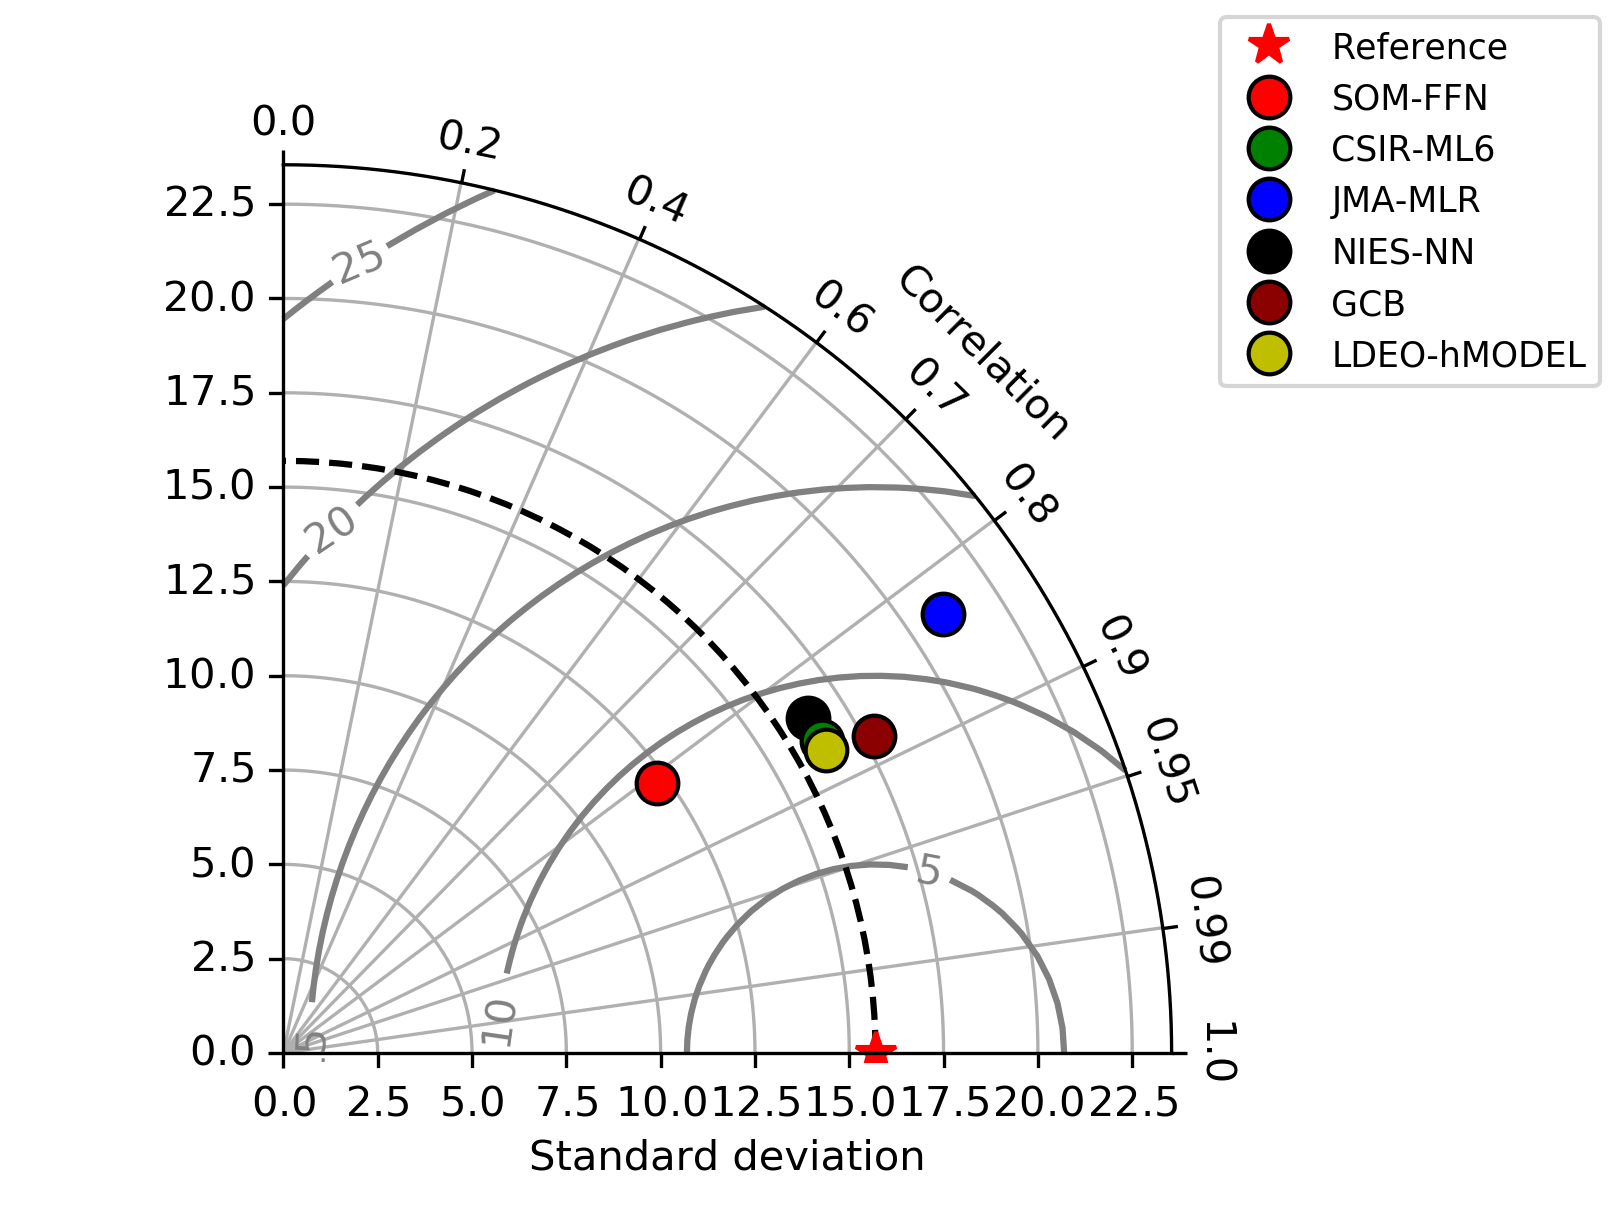

In [16]:
obs='HOT'

stats_SOM = sm.taylor_statistics(df['SOM-FFN'].values,df[obs].values,'data')
stats_HMODEL = sm.taylor_statistics(df['LDEO-HMODEL'].values,df[obs].values,'data')
stats_JMA = sm.taylor_statistics(df['JMA-MLR'].values,df[obs].values,'data')
stats_GCB = sm.taylor_statistics(df['GCB'].values,df[obs].values,'data')
stats_CSIR = sm.taylor_statistics(df['CSIR-ML6'].values,df[obs].values,'data')
stats_NIES = sm.taylor_statistics(df['NIES-NN'].values,df[obs].values,'data')

# Reference std
stdref = stats_HMODEL['sdev'][0]

# Samples std,rho,name
samples = [[stats_SOM['sdev'][1], stats_SOM['ccoef'][1], "SOM-FFN",'r'],
           [stats_CSIR['sdev'][1], stats_CSIR['ccoef'][1], "CSIR-ML6",'g'],
           [stats_JMA['sdev'][1], stats_JMA['ccoef'][1], "JMA-MLR",'b'],
           [stats_NIES['sdev'][1], stats_NIES['ccoef'][1], "NIES-NN",'k'], 
          [stats_GCB['sdev'][1], stats_GCB['ccoef'][1], "GCB",'darkred'],
          [stats_HMODEL['sdev'][1], stats_HMODEL['ccoef'][1], "LDEO-hMODEL",'y'],]

fig = plt.figure()

dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=False)
dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

# Add models to Taylor diagram
for i, (stddev, corrcoef, name, col) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker='o', ms=10, ls='',
                   mfc=col, mec='k',
                   label=name)

# Add RMS contours, and label them
contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

dia.add_grid()                                  # Add grid
dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

# Add a figure legend and title
fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='upper right')
#fig.suptitle("Taylor diagram", size='x-large')  # Figure title

#return dia

## TARGET DIAGRAM

In [17]:
obs='HOT'

stats_SOM = sm.target_statistics(df['SOM-FFN'].values,df[obs].values)
stats_HMODEL = sm.target_statistics(df['LDEO-HMODEL'].values,df[obs].values)
stats_JMA = sm.target_statistics(df['JMA-MLR'].values,df[obs].values)
stats_GCB = sm.target_statistics(df['GCB'].values,df[obs].values)
stats_CSIR = sm.target_statistics(df['CSIR-ML6'].values,df[obs].values)
stats_NIES = sm.target_statistics(df['NIES-NN'].values,df[obs].values)

# Store statistics in arrays
bias = np.array([stats_SOM['bias'], stats_HMODEL['bias'], 
                 stats_CSIR['bias'],stats_GCB['bias']])
crmsd = np.array([stats_SOM['crmsd'], stats_HMODEL['crmsd'], 
                 stats_CSIR['crmsd'],stats_GCB['crmsd']])
rmsd = np.array([stats_SOM['rmsd'], stats_HMODEL['rmsd'], 
                 stats_CSIR['rmsd'],stats_GCB['crmsd']])

# Samples std,rho,name
samples = [[list(stats_SOM.values())[:-1], "SOM-FFN",'r'],
           [list(stats_CSIR.values())[:-1], "CSIR-ML6",'g'],
           [list(stats_JMA.values())[:-1], "JMA-MLR",'b'],
           [list(stats_NIES.values())[:-1], "NIES-NN",'k'], 
          [list(stats_GCB.values())[:-1], "GCB",'darkred'],
          [list(stats_HMODEL.values())[:-1], "LDEO-HMODEL",'y'],]

In [18]:
sm.centered_rms_dev()

TypeError: centered_rms_dev() missing 2 required positional arguments: 'predicted' and 'reference'

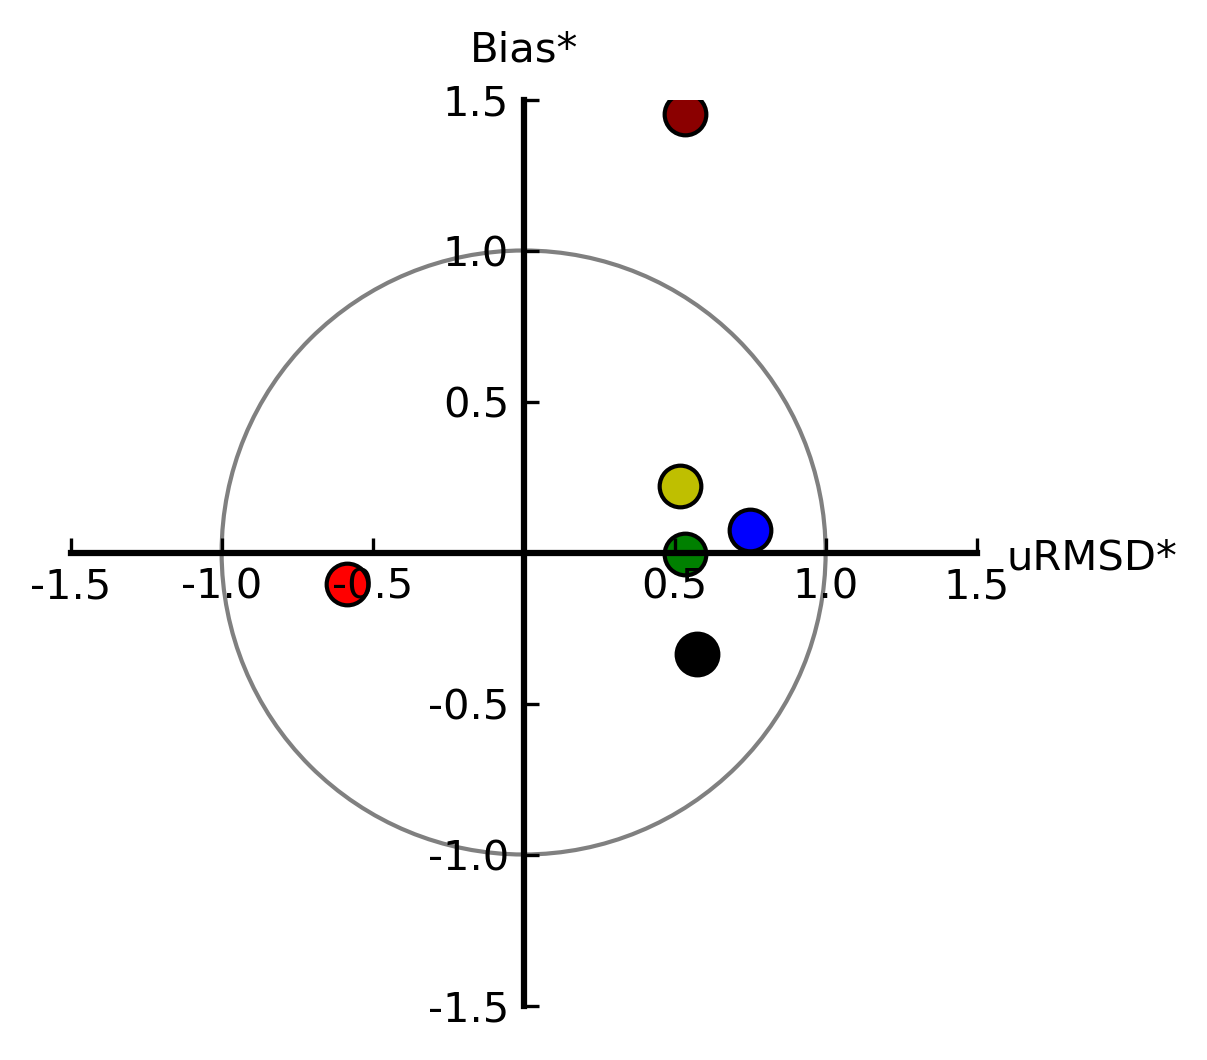

In [19]:
obs='HOT'
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot(111)
ax = target_axes(ax)

for (stats, mod, col) in samples:
    bias = stats[0]/df[obs].std()
    crmsd = (stats[1]/df[obs].std())*np.sign(df[mod].std() - df[obs].std())
    rmsd = stats[2]
    ax.scatter(crmsd, bias, c=col,s=100, edgecolors='k')
    
#plt.xlabel('adsf')

## _TRASH Target example

In [ ]:
#fig = plt.figure(figsize=(4,4)) 
#ax = fig.add_subplot(111)
#  Get axis values for plot
# Get options
option = get_target_diagram_options()

axes = get_target_diagram_axes(np.arange(-5,5,1),np.arange(-5,5,1)*2,option)

ax = plot_target_axes(axes)

ax.scatter(np.arange(-5,5,1),np.arange(-5,5,1)*2)

In [ ]:

for (stats, mod, col) in samples:
    bias = stats[0]/df[mod].std()
    crmsd = (stats[1]/df[mod].std())*np.sign(df[mod].std() - df[obs].std())
    rmsd = stats[2]
    sm.target_diagram(bias, crmsd, rmsd, 
                      ticks=np.arange(-1.5,1.5,0.5), 
                      markerColor=col,
                      markerSize=15, circles=[1])